In [1]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=f7e888c0bec08df10b728bb4d93912787d047ba2aed51c2d9a40947ff2e29111
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [2]:
!apt update
!apt install -y cmake
!pip install dlib

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downlo

In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (3,020 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [4]:
# from google.colab import files
# uploaded = files.upload()

In [5]:
 #!/usr/bin/env python
import os
import os.path
import json
import sys
import pytesseract
import re
import csv
import dateutil.parser as dparser
from PIL import Image
import shutil
import random
import numpy as np
import cv2
import os,glob
import face_recognition
from google.colab.patches import cv2_imshow
import cv2
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [6]:
def findencoding(cropped):
    cropped=cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    encode=face_recognition.face_encodings(cropped)
    return(encode)

In [7]:
def read_img(p):
    # img = Image.open(p)
    # display(img)
    img=cv2.imread(p)
    (h,w)=img.shape[:2]
    width=500
    ratio=width/float(w)
    height=int(h*ratio)
    return cv2.resize(img, (width, height))

In [8]:
# todo: move to function
def verify_person(year_of_birth,person_gender,photo_id,photo_clicked)->dict:
  img=Image.open(photo_id)
  img = img.convert('RGBA')
  pix = img.load()

  for y in range(img.size[1]):
      for x in range(img.size[0]):
          if pix[x, y][0] < 102 or pix[x, y][1] < 102 or pix[x, y][2] < 102:
              pix[x, y] = (0, 0, 0, 255)
          else:
              pix[x, y] = (255, 255, 255, 255)

  # img.save('/content/temp.png')

  pytesseract.pytesseract.tesseract_cmd = (
      r'/usr/bin/tesseract'
  )

  image_path_in_colab=photo_id
  text = pytesseract.image_to_string(Image.open(photo_id))

  print(text)

  yearline = []
  genline = []
  text1 = []
  text2 = []
  genderStr = '(Female|Male|emale|male|ale|FEMALE|MALE|EMALE)$'
  lines = text

  for wordlist in lines.split('\n'):
      xx = wordlist.split()
      if [w for w in xx if re.search('(Year|Birth|irth|YoB|YOB:|DOB:|DOB)$', w)]:
          yearline = wordlist
          break
      else:
          text1.append(wordlist)
  try:
      text2 = text.split(yearline, 1)[1]
  except Exception:
      pass


  try:
      yearline = re.split('Year of Birth|Birth|irth|YoB|YOB:|DOB:|DOB', yearline)[1:]
      yearline = ''.join(str(e) for e in yearline)
      if yearline:
          ayear = dparser.parse(yearline, fuzzy=True).year
  except Exception:
      pass
  birth=yearline[1::]

  ans_dict = {}

  ans_dict["yob"]=birth

  # Searching for Gender
  try:
      for wordlist in lines.split('\n'):
          xx = wordlist.split()
          if [w for w in xx if re.search(genderStr, w)]:
              genline = wordlist
              break 

      if 'Female' in genline or 'FEMALE' in genline:
          gender = "Female"
      if 'Male' in genline or 'MALE' in genline:
          gender = "Male"

      text2 = text.split(genline, 1)[1]
  except Exception:
      gender = "Other"
  
  ans_dict["gender"]=gender

  image = cv2.imread(photo_id)
  cropped = image[180:400, 200:400]
  cv2_imshow(cropped)
  cv2.waitKey(0)

  encodelistknown=findencoding(cropped)

  p=photo_clicked
  imgs=read_img(p)
  imgs=cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)

  facescurrframe=face_recognition.face_locations(imgs)
  encodecurrframe=face_recognition.face_encodings(imgs,facescurrframe)

  for encodeface,faceloc in zip(encodecurrframe, facescurrframe):
    matches=face_recognition.compare_faces(encodelistknown, encodeface)
    facedistance=face_recognition.face_distance(encodelistknown, encodeface)

  if (str(year_of_birth) == str(birth) and facedistance<0.5):
    # TODO: add to response
    print("Authentication Passed")
    ans_dict["verified"]=True
  else:
    # TODO: add to response
    # print("Enter the Correct information ")
    ans_dict["verified"]=False
  
  return ans_dict

In [9]:
import socket
print(socket.gethostbyname(socket.gethostname()))

172.28.0.2


In [10]:
import flask
!pip install flask-ngrok

In [11]:
from flask import Flask, jsonify, make_response, request
from flask_ngrok import run_with_ngrok
import threading
from flask import json

In [12]:
app=Flask(__name__)
run_with_ngrok(app)
app.config['UPLOAD_FOLDER'] = './'


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://2064325659ce.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [18/Oct/2020 19:44:48] "POST /idverify HTTP/1.1" 500 -


400 Bad Request: The browser (or proxy) sent a request that this server could not understand.
ART AHL

.
_ “QRVSGovERNMENT OF INDIA
TaN acear

Vasudha Tapriya
tar : dre arasar
Father : Sandeep Tapriya

3A af / Year of Birth 1999

afgat / Female

 



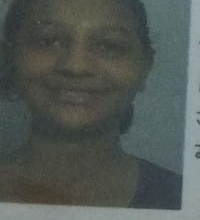

127.0.0.1 - - [18/Oct/2020 19:45:57] "POST /idverify HTTP/1.1" 200 -


Authentication Passed


In [ ]:
@app.route('/idverify',methods=['POST'])
def idverify():
  try:
    form_data = request.form
    photo_id_img = request.files['photo_id']
    photo_clicked_img = request.files['photo_clicked']

    photo_id_img.save(os.path.join(app.config['UPLOAD_FOLDER'], photo_id_img.filename))
    photo_clicked_img.save(os.path.join(app.config['UPLOAD_FOLDER'], photo_clicked_img.filename))

    response_dic = verify_person(form_data['yob'],
                                 form_data['gender'],
                                 photo_id_img.filename,
                                 photo_clicked_img.filename)
    response = app.response_class(
          response=json.dumps(response_dic),
          status=200,
          mimetype='application/json'
      )
    return (response)

  except Exception as e:
    print(e)
    response = app.response_class(
          response=json.dumps({"error":"error verifying user"}),
          status=500,
          mimetype='application/json'
    )
    return response
  
  try: 
    os.remove(photo_clicked_img.filename)
    os.remove(photo_id.filename)
  except Exception as e:
    print(e)

app.run()